## Using a GPU

You will need to have the fastai library installed for this lesson, and you will want to use a GPU to train your neural net.  If you don't have a GPU you can use in your computer (currently, only Nvidia GPUs are fully supported by the main deep learning libraries), no worries!  There are a number of cloud options you can consider:

[GPU Cloud Options](https://course.fast.ai/#using-a-gpu)

**Reminder: If you are using a cloud GPU, always be sure to shut it down when you are done!!! Otherwise, you could end up with an expensive bill!**

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *

In [3]:
import fastai.utils.collect_env

#fastai.utils.collect_env.show_install()

Note that language models can use a lot of GPU, so you may need to decrease batchsize here.

In [4]:
bs=100
# bs=24
#bs=192

In [5]:
torch.cuda.set_device(0)

## Preparing the data (on a sample)

In [6]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/home/momgpu/.fastai/data/imdb/test'),
 PosixPath('/home/momgpu/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/momgpu/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/momgpu/.fastai/data/imdb/README'),
 PosixPath('/home/momgpu/.fastai/data/imdb/lm_databunch'),
 PosixPath('/home/momgpu/.fastai/data/imdb/train'),
 PosixPath('/home/momgpu/.fastai/data/imdb/tmp_clas'),
 PosixPath('/home/momgpu/.fastai/data/imdb/models'),
 PosixPath('/home/momgpu/.fastai/data/imdb/unsup')]

And if we look at what a what's in our datasets, we'll see the tokenized text as a representation:

In [ ]:
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1, seed=42)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs, num_workers=1))

In [ ]:
data_lm.train_ds[0][0]

But the underlying data is all numbers

In [ ]:
data_lm.train_ds[0][0].data[:10]

In [ ]:
len(data_lm.vocab.itos),len(data_lm.train_ds)

In [ ]:
data_lm.show_batch()

#### Saving

In [ ]:
data_lm.save('lm_databunch')

#### Loading

In [7]:
data_lm = load_data(path, 'lm_databunch', bs=bs)

 ### Setting up a training


In [8]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [10]:
path.ls()

[PosixPath('/home/momgpu/.fastai/data/imdb/test'),
 PosixPath('/home/momgpu/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/momgpu/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/momgpu/.fastai/data/imdb/README'),
 PosixPath('/home/momgpu/.fastai/data/imdb/lm_databunch'),
 PosixPath('/home/momgpu/.fastai/data/imdb/train'),
 PosixPath('/home/momgpu/.fastai/data/imdb/tmp_clas'),
 PosixPath('/home/momgpu/.fastai/data/imdb/models'),
 PosixPath('/home/momgpu/.fastai/data/imdb/unsup')]

In [12]:
wiki_itos = pickle.load(open(Config().model_path()/'wt103-1/itos_wt103.pkl', 'rb'))

FileNotFoundError: [Errno 2] No such file or directory: '/home/momgpu/.fastai/models/wt103-1/itos_wt103.pkl'

In [ ]:
Config().model_path()

In [ ]:
TEXT = "The lion king"
N_WORDS = 30
N_SENTENCES = 2

In [ ]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.1) for _ in range(N_SENTENCES)))

In [9]:
learn_lm.fit_one_cycle(2, 4.004e-4, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.159873,4.035809,0.292944,19:23
1,4.099949,4.003391,0.295622,19:22


In [10]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(4, slice(1e-2/(2.6**4),1e-2), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.912029,3.840283,0.312475,21:33
1,3.784147,3.710095,0.325792,21:35
2,3.621508,3.611122,0.336274,21:34
3,3.459324,3.583950,0.339998,21:34


In [14]:
learn_lm.save("trainedNLP32")
learn_lm.save_encoder("trainedNLP32_enc")

Path for saved models are : 


./.fastai/data/imdb/models/trainedNLP32_enc.pth


./.fastai/data/imdb/models/trainedNLP32.pth


In [15]:
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


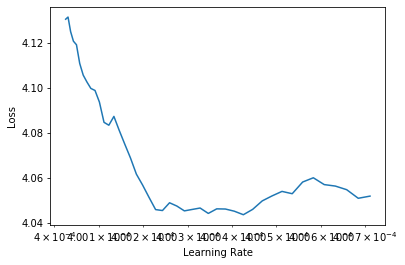

In [18]:
learn_lm.recorder.plot()